# Kapitel 12 - Neuronale Netze mit Keras

In [16]:
#check if gpu is available
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

[]

## Kapitel ?.2. Implementierung mit Keras

<div class="alert alert-warning">
<b>Aufgabe:</b> Kapitel 3 - Einführung in Neuronale Netze
    
Lesen Sie Kapitel 3 und implementieren Sie die Beispiele in einem Jupyter Notebook. Besonderer Fokus sollte auf Kapitel 3.5 gelegt werden. Kapitel 3.6 sollten Sie zwar lesen, Regression wird in dieser Tutorialreihe jedoch nicht weiter behandelt.

<b>Hinweise</b>:
- Wenn eine NVIDIA Grafikkarte mit GPU vorhanden, am besten auf der GPU trainieren. <b>Achtung</b>: Der Installationsprozess kann teilweise sehr frustrierend sein. Achten Sie auf die richtigen Version. Onlineguides sollten Ihnen dabei helfen.
- Sollte keine GPU vorhanden sein oder die Installation nicht funktionieren, empfehle ich, <a href="https://colab.research.google.com/notebooks/welcome.ipynb#recent=true"><b>Google Colab</b></a> zu nutzen. Google Colab funktioniert ähnlich wie Jupyter Notebooks und bietet kostenlosen GPU-Speicher. Unter `File/Open Notebook` können Jupyter Notebooks geladen werden. Unter `Runtime/Change runtime type` kann als Hardware accelerator die GPU ausgewählt werden. Am Anfang jedes der folgenden Tutorial-Notebooks stelle ich zwei Zeilen Code zur Verfügung, mit denen getestet werden kann, ob die GPU verfügbar ist. Dies sollte immer vor dem eigentlichen Training getestet werden.
- Chollet benutzt die <b>One-Hot-Codierung</b> nicht immer richtig. Verwenden Sie am besten immer `to_categorical` von `from keras.utils.np_utils import to_categorical` anstatt den Code, den Chollet selbst erstellt hat.


<b>Aufgaben</b>:
- Führen Sie einige der Experimente in aus 3.4.6. aus.
- 


<b>Optional</b>:<br>
- 

In [63]:
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### Korpus laden

In [20]:
corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

#### Vektorisieren der Daten

Die Trainings- und Testdatensätze teilen wir nicht sonst üblich 80/20, sondern 60/40. Der Grund dafür ist, dass wir im Anschluss einen Validierungdatensatz aus den Testdatensätzen erzeugen, indem wir die Testdatensätze halbieren. Am Ende haben wir die Aufteilung 60/20/20 (Trainingsdatensatz/Validierungsdatensatz/Testdatensatz).<br>
Zudem erstellen wir ein Dictionary mit dem Namen `vocab`, welches alle in unseren Texten vorkommende Wörter mit ihrer Häufigkeit speichern. Dieses benötigen wir für unser Modell.

In [78]:
vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])
vocab = vectorizer.vocabulary_




X_train, X_test, y_train, y_test = train_test_split(vector, 
                                                    labels, 
                                                    test_size=0.4, 
                                                    train_size=0.6,
                                                    random_state=42)
X_val = X_test[:1200]
X_test = X_test[1200:]

y_val = y_test[:1200]
y_test = y_test[1200:]

#### One-hot-Codierung der Label

TODO: One-hot-Codierung erklären!

In [79]:
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

#### Ein Neuronales Netz für Multiclass Klassifizierung

Unser Modell besteht aus einem Input-Layer, einem Hidden-Layer und einem Output-Layer. Wir haben hier ein 2-layer Netz vorliegen (der Input-Layer wird nicht mitgezählt). Als Aktivierungsfunktion benutzen wir die RELU-Funktion (siehe Kapitel 3.4.3). Als <i>hidden units</i> (deutsch: verdeckte Einheit, siehe Kapitel 3.4.3)<br> haben wir `64` gewählt.
Im Input-Layer gibt es den Parameter `input_shape`. Dieser gibt an, welche Dimension die Daten haben. Hier können wir die Länge unseres Vokabulars angeben, d.h. die Anzahl der verschiedenen Wörter unseres Korpus. Im Output-Layer müssen wir die Dimension des Vektors angeben, die das Neuronale Netz für jede Eingabe ausgibt. Da unser Korpus 30 verschiedene Kategorien besitzt, muss hier `30` stehen. Um sicher zu gehen, dass die Dimension auch wirklich passt, geben wir `len(np.unique(labels))` an, also die Anzahl aller einzigarten Labelbezeichnungen. Als Optimizer haben wir <b>rmsprop</b> verwendet. Auf die Wahl der Optimizer werden wir später noch eingehen. Als Loss Function wählen wir <b>categorical_crossentropy</b>, die Umsetzung der cross entropy für mehr als 2 Klassen. Als Metrik nehmen wir die Classification accuracy (`accuracy`). In Kapitel 5 hatten wir eigentlich den <b>F1-score</b> als Evaluationsmaß festgelegt. Keras bietet jedoch seit der <a href="https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes">Version 2.0</a> keinen F1-score mehr an (der <a href="https://github.com/keras-team/keras/issues/5794">Grund</a>). Wir werden zunächst ebenfalls nur die Classification Accuracy nutzen und den F1-score erst nach dem Training des Modells nutzen.

In [123]:
model = models.Sequential()
# Input Layer
model.add(layers.Dense(64, activation="relu", input_shape=(len(vocab),)))
# Hidden Layer
model.add(layers.Dense(64, activation="relu"))
# Output Layer
model.add(layers.Dense(len(np.unique(labels)), activation="softmax"))


model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

Hier trainieren wir unser Modell für 10 Epochen mit einer `batch_size` von `64`. Wenn kein Fortschrittsbalken erwünscht ist, muss auf `verbose = 0` gestellt werden. Das Modell speichern wir im `history`-Objekt, welches uns Auskunft über die verschiedenste beim Training vorgefallenen Ereignisse liefert.<br>
Bei der Ausführung auf einer CPU dauert das Training etwa drei Minuten, auf einer GPU nur wenige Sekunden.

In [124]:
history = model.fit(X_train,
                   y_train,
                   epochs=10,
                   batch_size=64,
                   validation_data=(X_test, y_test),
                   verbose=1)

Train on 3600 samples, validate on 1200 samples
Epoch 1/10
3600/3600 [==============================] - 18s 5ms/step - loss: 3.1788 - acc: 0.3697 - val_loss: 2.8545 - val_acc: 0.5358
Epoch 2/10
3600/3600 [==============================] - 18s 5ms/step - loss: 2.2308 - acc: 0.8081 - val_loss: 1.9175 - val_acc: 0.8025
Epoch 3/10
3600/3600 [==============================] - 18s 5ms/step - loss: 1.1233 - acc: 0.9661 - val_loss: 1.1336 - val_acc: 0.8992
Epoch 4/10
3600/3600 [==============================] - 18s 5ms/step - loss: 0.4340 - acc: 0.9956 - val_loss: 0.7021 - val_acc: 0.9083
Epoch 5/10
3600/3600 [==============================] - 20s 5ms/step - loss: 0.1475 - acc: 0.9983 - val_loss: 0.4760 - val_acc: 0.9258
Epoch 6/10
3600/3600 [==============================] - 20s 5ms/step - loss: 0.0475 - acc: 0.9997 - val_loss: 0.3681 - val_acc: 0.9258
Epoch 7/10
3600/3600 [==============================] - 19s 5ms/step - loss: 0.0145 - acc: 0.9997 - val_loss: 0.3151 - val_acc: 0.9267
Epoch 8

#### Visualisieren der Ergebnisse

Für die Visualisierung der Ergebnisse fassen wir die Visualisierungsmethode aus dem Buch in einer Funktion `plot_results` zusammen. Im weiteren Verlauf der Tutorialreihe werden wir diese Visualisierungen nutzen, um unsere Ergebnisse zu interpretieren.

In [125]:
def plot_results(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "ro", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

    plt.clf() #clears the figure

    acc = history.history["acc"]
    val_acc = history.history["val_acc"]

    plt.plot(epochs, acc, "b", label="Training acc")
    plt.plot(epochs, val_acc, "ro", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Acc")
    plt.legend()

    plt.show()

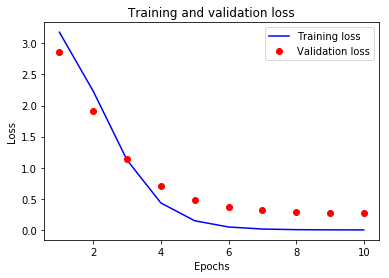

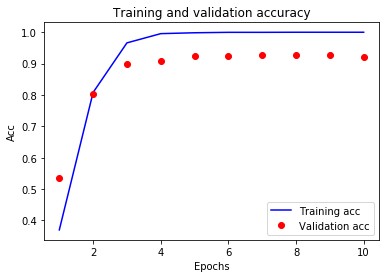

In [126]:
plot_results(history)

<u>Interpretation</u>:<br>
Die Loss Function verhält sich so, wie sie sollte, d.h. die Loss scores nehmen stetig ab und tendieren gegen Null. Die Trainings accuracy erreicht ab Epoche 4 100%, ein Wert, der uns eigentlich zeigen sollte, dass unser Modell perfekt auf unsere Daten trainiert hat. Jedoch messen wir während des Trainingsvorgangs auch unsere Validation accuracy die ab Epoche 4 etwa bei 92,5% liegt. Der Unterschied zwischen diesen beiden Werten sollte geringer sein, damit das Modell als gültiges Modell angesehen werden kann (AF!). Unser Modell <b>overfittet</b>, d.h. es passt sich zu stark an die Trainingsdaten an. In einem späteren Abschnitt werden wir uns dem Overfitting widmen. 

## ?.3. Evaluierung eines Keras Modells

#### Berechnung des F1-scores

Wir können den F1-score nun berechnen, da unser Modell fertig trainiert ist. Anders als bei Scikit learn müssen wir hier jedoch zuvor `np.argmax` anwenden, welches den Index des größten Wertes jeder Zeile zurückgibt.

In [138]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)
f1_keras = f1_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), average="micro")
print("Der F1-score für die Klassifizierung mit Keras ist "
      + f"{str(np.around(lr_f1, decimals=3))}.")

Der F1-score für die Klassifizierung mit Keras ist 0.92.


#### Evaluation

Nun schauen wir uns die verschiedenen Scores an. Die Test accuracy, die Training accuracy und der F1-score haben alle etwa den Wert 0.92, nur die Validation accuracy ist niedriger. Wie bereits erwähnt bedeutet dies, dass unser Modell <b>overfittet</b>.

In [140]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\nResults:")
print(f"Train_acc: {np.around(np.mean(history.history['acc']), decimals=3)}")
print(f"Val_acc: {np.around(np.mean(history.history['val_acc']), decimals=3)}")
print(f"Test_acc: {np.around(test_acc, decimals=3)}") 
print(f"F1-score: {str(np.around(lr_f1, decimals=3))}")

1200/1200 [==============================] - 2s 2ms/step

Results:
Train_acc: 0.914
Val_acc: 0.87
Test_acc: 0.92
F1-score: 0.92


#### Cross validation mit Keras

Für eine Evaluierung von Keras Modellen können wir auch Cross Validation nutzen. Während es im Bereich des Machine Learning ein Gold-Standard für die Evaluierung von Klassifikationsverfahren ist, wird es im Bereich des Deep Learning nur selten eingesetzt. Deep Learning Modelle sind meist komplexer als die meisten Machine Learning Klassifikationsverfahren und können selbst auf einer GPU mehrere Stunde dauern. Eine Cross Validation würde deshalb sehr viel Rechenzeit benötigen. Bei kleineren Modellen kann es jedoch ein gutes Performance-Maß sein. Als Cross validation Methode nutzen wir hier <b>StratifiedKFold</b>, die Funktionsweise kann in der <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html">Dokumentation</a> eingesehen werden. Da StratifiedKFold mit One-Hot-Encoding nichts anfangen kann, müssen wir das Korpus noch einmal neu laden.

In [170]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

corpus = pd.read_csv("tutorialdata/corpora/wikicorpus_v2.csv")

vectorizer = TfidfVectorizer()
vector = vectorizer.fit_transform(corpus["text"])
labels = LabelEncoder().fit_transform(corpus["category"])


kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
kfold.get_n_splits(X, y)

cv_scores = []


for train, test in kfold.split(X, y):
    
    X_train = vectorizer.fit_transform(X[train])
    y_train = LabelEncoder().fit_transform(y[train])
    X_test = vectorizer.fit_transform(X[test])
    y_test = LabelEncoder().fit_transform(y[test])
    
    y_test = to_categorical(y_test)
    y_train = to_categorical(y_train)
    
    
    
    print(y_test.shape)
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(30, activation="softmax"))
    
    model.compile(optimizer="rmsprop",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    model.fit(X_train, y_train, validation_data=(X_test, y_test),
              epochs=10, batch_size=64, verbose=0)
    
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cv_scores.append(scores[1] * 100)


print("%.2f%% (+/- %.2f%%)" % (np.mean(cv_scores), np.std(cv_scores)))

(2010, 30)


ValueError: Error when checking input: expected dense_73_input to have shape (215831,) but got array with shape (140959,)

TODO
- https://machinelearningmastery.com/multi-class-classification-tutorial-keras-deep-learning-library/